# Inverse Compton Scattering

## Notebook Initialization

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle

from astropy.io import fits

import darkhistory.physics as phys
import darkhistory.spec.spectrum as spec
import darkhistory.spec.transferfunction as tf
from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec

## Nonrelativistic Spectrum - Checks

`nonrel_ICS_tf` is the `TransFuncAtRedshift` saved from running our computation of the nonrelativistic spectrum at a 1+z = 1000. `nonrel_ICS_file_tf` is the spectrum computed by Tracy's original IDL code. It has to be processed into a `TransFuncAtRedshift`. 

In [3]:
nonrel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))

file_name_nonrel = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/thomsontable.fits"
file_nonrel = fits.open(file_name_nonrel)
lowengEp_file_nonrel = file_nonrel[1].data[0][0]
lowengEe_file_nonrel = file_nonrel[1].data[0][1]
nonrelspec_file = np.array(file_nonrel[1].data[0][2])
nonrel_ICS_file_tf = tf.TransFuncAtRedshift(
    [spec.Spectrum(lowengEp_file_nonrel, ICS_array, 1000) for ICS_array in nonrelspec_file],
    in_eng=lowengEe_file_nonrel-510998.903, dlnz=1
)

[0.0001, 1000000000000.0, 1e-18, 1]

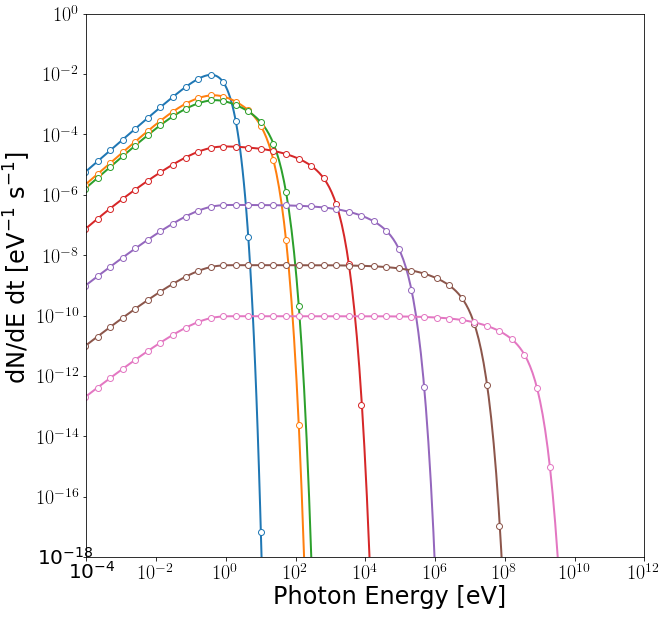

In [4]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

comp_elec_eng = np.array([2e-8, 7e5, 1e6, 1e7, 1e8, 1e9, 7e9])

nonrel_ICS_tf.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)

# Resets the color choices
plt.gca().set_prop_cycle(None)

nonrel_ICS_file_tf.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=0,
                       marker='o', markersize='6', 
                        markevery=100, markerfacecolor='w')

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e12, 1e-18, 1])


## Relativistic Spectrum - Checks

In [5]:
rel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))

file_name_rel = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/kntable.fits"
file_rel = fits.open(file_name_rel)

lowengEp_file_rel = file_rel[1].data[0][0]
lowengEe_file_rel = file_rel[1].data[0][1]
relspec_file = np.array(file_rel[1].data[0][2])
rel_ICS_file_tf = tf.TransFuncAtRedshift(
    [spec.Spectrum(lowengEp_file_rel, ICS_array, 1000) for ICS_array in relspec_file],
    in_eng=lowengEe_file_rel, dlnz=1
)

[1e-08, 1e+20, 1e-30, 1000000.0]

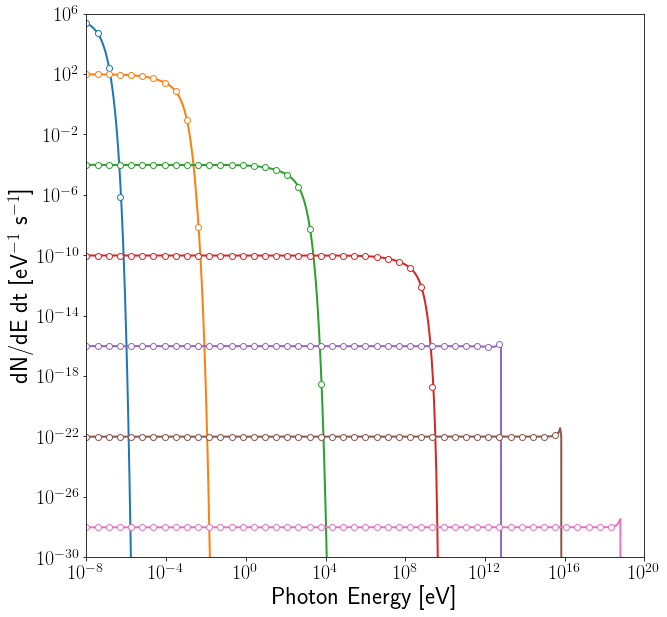

In [6]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

comp_elec_eng = np.array([7e1, 7e3, 7e6, 7e9, 7e12, 7e15, 7e18])

rel_ICS_tf.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)

plt.gca().set_prop_cycle(None)

rel_ICS_file_tf.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=0,
                    marker='o', markersize='6', 
                        markevery=100, markerfacecolor='w')

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-8, 1e20, 1e-30, 1e6])

## Energy Loss Spectrum - Checks

In [7]:
engloss_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

file_name_engloss = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/thomson_engloss_table_fixed.fits"
file_engloss = fits.open(file_name_engloss)
lowengEp_file_engloss = file_engloss[1].data[0][0]
lowengEe_file_engloss = file_engloss[1].data[0][1]
englossspec_file = np.array(file_engloss[1].data[0][2])
engloss_file_tf = tf.TransFuncAtRedshift(
    [spec.Spectrum(lowengEp_file_engloss, ICS_array, 1000) for ICS_array in englossspec_file], 
    in_eng = lowengEe_file_engloss-510998.903, dlnz=1
)

[1e-08, 1000000000000.0, 1e-18, 1]

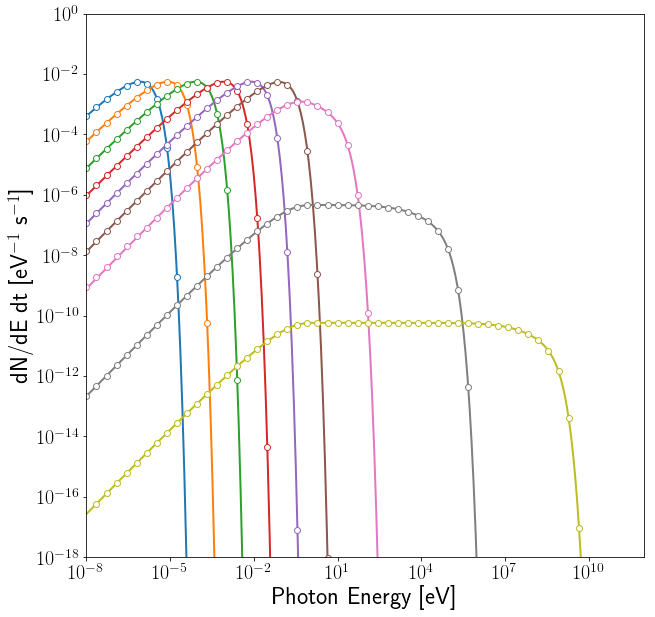

In [8]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

comp_elec_eng = np.array([1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6, 1e8, 9e9])

engloss_tf.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)

plt.gca().set_prop_cycle(None)

engloss_file_tf.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=0,
                    marker='o', markersize='6', 
                        markevery=100, markerfacecolor='w')


ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-8, 1e12, 1e-18, 1])

## Comparing Direct Computation with Table Lookup - ICS Spectrum

In [9]:
# %%prun
nEe = 500
nEp = 500

Emax_rel = 1e20
Emin_rel = 1e-8

dlnEp = np.log(Emax_rel/Emin_rel)/nEp
lowengEp = Emin_rel*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax_rel/Emin_rel)/nEe
lowengEe = phys.me + Emin_rel*np.exp((np.arange(nEe)+0.5)*dlnEe)

computed_ICS_tf = ics_spec(lowengEe, lowengEp, phys.TCMB(10))
table_ICS_tf = ics_spec(lowengEe, lowengEp, phys.TCMB(10), 
             nonrel_tf=nonrel_ICS_tf, rel_tf=rel_ICS_tf)

Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!
Initializing...
Computing spectra by an expansion in beta...
Computing Q and K terms...
Computing H and G terms...
Computation by expansion in beta complete!
Computing errors for beta expansion method...
Computing spectra by analytic series...
Computing series 1/8...
Computing series 2/8...
Computing series 3/8...
Computing series 4/8...
Computing series 5/8...
Computing series 6/8...
Computing series 7/8...
Computing series 8/8...
Computation by analytic series complete!
Spectrum computed!


[1e-08, 1e+20, 1e-30, 0.0001]

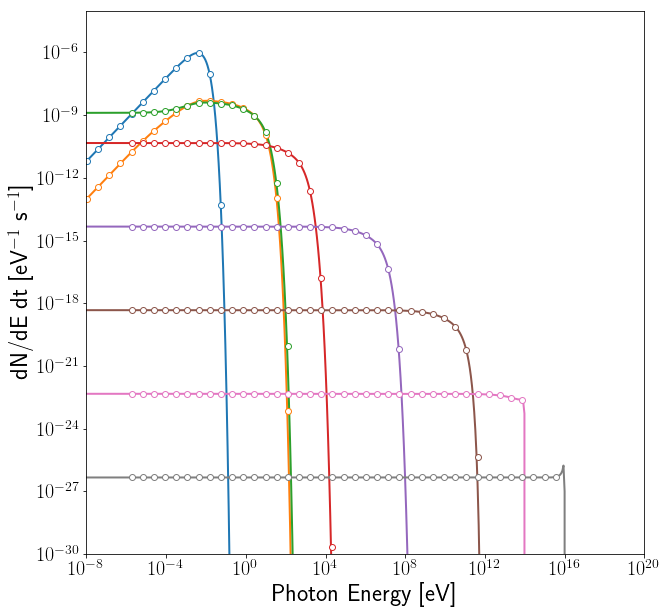

In [10]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([1e-4, 9e6, 1e7, 1e8, 1e10, 1e12, 1e14, 1e16])

computed_ICS_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)

plt.gca().set_prop_cycle(None)

table_ICS_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=0, 
                 marker='o', markersize='6', 
                        markevery=10, markerfacecolor='w')
ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-8, 1e20, 1e-30, 1e-4])

## Comparing Direct Computation with Table Lookup - Energy Loss Spectrum

In [12]:
Emax = 1e20
Emin = 1e-8
nEe = 400
nEp  = 400

dlnEp = np.log(Emax/Emin)/nEp
delta_engloss = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax/Emin)/nEe
lowengEe_engloss = phys.me + Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)
computed_engloss_tf = engloss_spec(lowengEe_engloss, delta_engloss, phys.TCMB(10))
table_engloss_tf = engloss_spec(lowengEe_engloss, delta_engloss, phys.TCMB(10),
                     rel_tf = rel_ICS_file_tf, nonrel_tf = engloss_tf)

Computing relativistic energy loss spectrum...
Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!
Relativistic energy loss spectrum complete!
Computing nonrelativistic energy loss spectrum...
Computing energy loss spectrum by beta expansion...
(1/5) Computing F1_up - F1_down term...
(2/5) Computing F0_up - F0_down term...
(3/5) Computing F0_up + F0_down term...
(4/5) Computing F_inv_up - F_inv_down term...
(5/5) Computing F_rem term...
Computation by expansion in beta complete!
Computing energy loss spectrum by analytic series...
Computing upscattering loss spectra...
Computing series 1/7...
Computing series 2/7...
Computing series 3/7...
Computing series 4/7...
Computing series 5/7...
Computing series 6/7...
Computing series 7/7...
Computing downscattering loss spectra...
Computing series 1/7...
Computing series 2/7...
Computing series 3/7...
Computing series 4/7...
Computing series 5/7...


[1e-08, 1e+16, 1e-24, 0.0001]

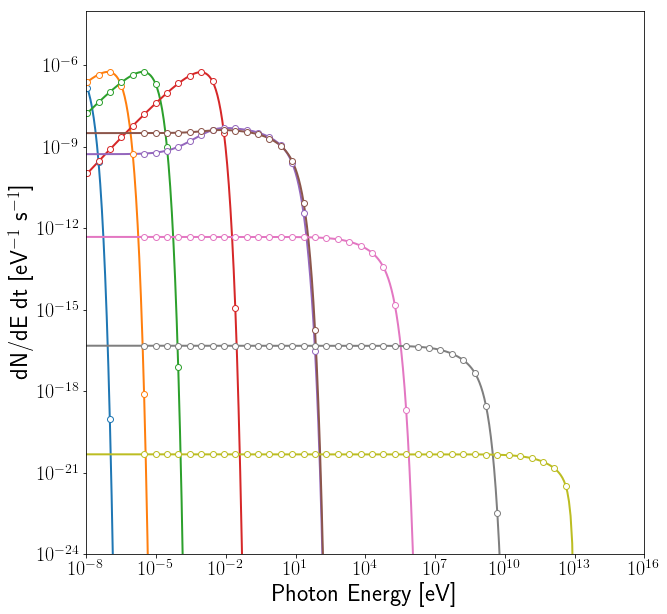

In [13]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

comp_elec_kineng = np.array([1e-7, 1e-4, 1e-1, 1e4, 9e6, 1e7, 1e9, 1e11, 1e13])

computed_engloss_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)

plt.gca().set_prop_cycle(None)

table_engloss_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=0, 
                 marker='o', markersize='6', 
                        markevery=7, markerfacecolor='w')
ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-8, 1e16, 1e-24, 1e-4])